# Set-up

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from utils import get_timestamp_from_gme_system, hour_gain_days, hour_loss_days
from os.path import join
import os
from tqdm.notebook import tqdm
sns.set_theme()

In [2]:
pd.options.mode.chained_assignment = None

In [58]:
scope = 'OFF'

cal = {
    'OFF': '_CALIBRATED',
    'BID': '_CALIBRATED'
}

unit = {
    'OFF': 'UP_LA_CASELL_2',
    'BID': 'UP_VADOTERM_5'
}

example_bid = {
    'OFF': '2022012213UP_LA_CASELL_2_OFF',
    'BID': '2022012822UP_VADOTERM_5_BID'
}

input_path = f'data/2_processed/ML_dataset_{scope}.pkl'
predictions_path = f'modeling/{scope}/model_predictions/RF_predicted_probs_monthly_recal_rolling_12m{cal[scope]}.pkl'
model_folder = f'modeling/{scope}/model_dumps/classifier'
calibrator_folder = f'modeling/{scope}/model_dumps/calibrator'
fig_folder = f'plots/{scope}/pricing'

In [59]:
target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVnew',
    'PriceDiff',
    'Qty'
]

features = other_features + features_to_encode

# Load dataset, model predictions and model

In [60]:
input_df = pd.read_pickle(input_path)

In [61]:
df = input_df.copy()
y_probs = pd.read_pickle(predictions_path)
df['month'] = df.index.str[4:6].astype(int)
df['y_probs'] = y_probs

In [62]:
# Load calibrators
calibrators = {}
for calibrator in os.listdir(calibrator_folder):
    month = calibrator[:6]
    calibrators[month] = joblib.load(join(calibrator_folder, calibrator))

In [63]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough"
)

In [64]:
def predict_acc_prob(df, clf, calibrator=None):
    X = feature_transformer.fit_transform(df[features])
    y_probs = clf.predict_proba(X)[:,1]
    if calibrator:
        y_probs_cal = calibrator.predict(y_probs)
        # Sometimes the isotonic regression creates na so in this case we simply take the uncalibrated y
        y_probs_cal[np.isnan(y_probs_cal)] = y_probs[np.isnan(y_probs_cal)]
        return y_probs_cal
    else:
        return y_probs

# Pricing strategy example for one sampled bid

0.12597547380156077


,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty,month,y_probs
2022012213UP_LA_CASELL_2_OFF,13,20220122,2022,UP_LA_CASELL_2,OFF,5.363745,1.464939,2.726665,1.51316,-1.638724,...,Fossil Gas,0.0,0.0,290.0,0.181,False,0.0,185.0,1,0.144376


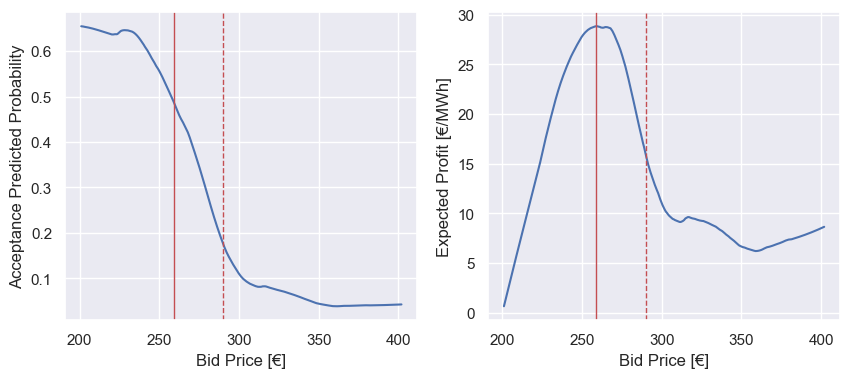

In [65]:
year = 2022
month = 1
tech = 'Fossil Gas'
marginal_cost = 200
n_prices = 300
random_state = None
smoothed = True
clf = joblib.load(f'modeling/{scope}/model_dumps/model_trained_{scope}_2021.joblib')

# bid = df[(df.year == year)&(df.Tech == tech)&(df.month == month)].sample(1, random_state=random_state)
bid = df[df.index == example_bid[scope]]

if scope == 'OFF':
    price_diff = np.linspace(0, 1/3, n_prices)
elif scope == 'BID':
    price_diff = np.linspace(-0.5, 0, n_prices)
simulated_bids = pd.concat([bid] * n_prices, ignore_index=True)

simulated_bids['PriceDiff'] = price_diff
simulated_bids['Price'] = simulated_bids['MGPprice'] * (1 + simulated_bids['PriceDiff']) / (1 - simulated_bids['PriceDiff'])
simulated_bids['y_probs'] = predict_acc_prob(simulated_bids, clf, calibrator=calibrators[f"{year:04d}{month:02d}"])
simulated_bids['y_probs_smoothed'] = savgol_filter(simulated_bids.y_probs, window_length=80, polyorder=3, mode='nearest')
if scope == 'OFF':
    simulated_bids['Expected Profit'] = (simulated_bids['Price'] - marginal_cost) * simulated_bids['y_probs{}'.format(smoothed*'_smoothed')]
elif scope == 'BID':
    simulated_bids['Expected Profit'] = (marginal_cost - simulated_bids['Price']) * simulated_bids['y_probs{}'.format(smoothed*'_smoothed')]

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(simulated_bids['Price'], simulated_bids['y_probs{}'.format(smoothed*'_smoothed')])
axs[1].plot(simulated_bids['Price'], simulated_bids['Expected Profit'])

axs[0].set_xlabel('Bid Price [€]')
axs[0].set_ylabel('Acceptance Predicted Probability')
# axs[0].set_title('Price vs. Predicted Probability')

axs[1].set_xlabel('Bid Price [€]')
axs[1].set_ylabel('Expected Profit [€/MWh]')
# axs[1].set_title('Price vs. Expected Profit')

for i in [0, 1]:
    axs[i].axvline(x=bid.Price.iloc[0], color='r', linestyle='--', linewidth=1) # Line for the actual bid price
    axs[i].axvline(x=simulated_bids.loc[simulated_bids['Expected Profit'].argmax(), 'Price'], color='r', linestyle='-', linewidth=1) # Line for the optimal bid price
plt.savefig(join(fig_folder, '{}.png'.format(bid.index[0])), dpi=300, bbox_inches='tight')

print(simulated_bids.loc[simulated_bids['Expected Profit'].argmax(), 'PriceDiff'])
bid

# Pricing strategy test for all bids of one unit

## Retrieve all bids of unit and marginal cost

In [66]:
years = [2020, 2021, 2022]

In [67]:
mc_df = pd.read_pickle('data/1_input/mgp_bid_prices.pkl')
mc_df.head()

,BID_OFFER_DATE_DT,INTERVAL_NO,UNIT_REFERENCE_NO,ENERGY_PRICE_NO
0,20200102,6,UP_VADOTERM_5,24.990000
1,20200102,7,UP_VADOTERM_5,29.158803
2,20200102,8,UP_VADOTERM_5,29.159058
3,20200102,9,UP_VADOTERM_5,28.494138
4,20200102,10,UP_VADOTERM_5,28.491186


In [68]:
sim_df = df[(df.unit == unit[scope]) & (df.year.isin(years))]
merge_df = sim_df.reset_index().merge(mc_df, left_on=['date', 'hour', 'unit'], right_on=['BID_OFFER_DATE_DT', 'INTERVAL_NO', 'UNIT_REFERENCE_NO'], how='left').set_index('index')
sim_df['cost'] = merge_df['ENERGY_PRICE_NO']
sim_df['timestamp'] = pd.to_datetime(df['date'].astype(str) + df['hour'].apply(lambda x: "{:02d}".format(x-1)), format='%Y%m%d%H')
sim_df['quarter'] = sim_df['timestamp'].dt.to_period('Q')
sim_df['month'] = sim_df['timestamp'].dt.to_period('M')
sim_df.set_index('timestamp', inplace=True)
sim_df = sim_df[~sim_df.index.duplicated(keep='first')] # We may have some duplicated indices for daylight saving time
sim_df.head()

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PVnew,Price,PriceDiff,Result,RatioAcc,Qty,month,y_probs,cost,quarter
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1,20200101,2020,UP_LA_CASELL_2,OFF,-0.463099,-1.096322,-3.173348,-0.453328,-0.604662,...,0.0,80.0,0.313,False,0.0,180.0,2020-01,0.001677,NaN,2020Q1
2020-01-01 01:00:00,2,20200101,2020,UP_LA_CASELL_2,OFF,-0.592628,-0.569294,-3.334570,-0.374736,-0.306465,...,0.0,80.0,0.349,False,0.0,180.0,2020-01,0.001677,NaN,2020Q1
2020-01-01 02:00:00,3,20200101,2020,UP_LA_CASELL_2,OFF,-0.043494,-0.962287,-3.467825,-0.323578,-0.076935,...,0.0,80.0,0.373,False,0.0,180.0,2020-01,0.001677,NaN,2020Q1
2020-01-01 03:00:00,4,20200101,2020,UP_LA_CASELL_2,OFF,1.168687,-1.048828,-3.636994,-0.287159,0.221691,...,0.0,80.0,0.425,False,0.0,180.0,2020-01,0.001677,NaN,2020Q1
2020-01-01 04:00:00,5,20200101,2020,UP_LA_CASELL_2,OFF,1.669252,-0.886962,-3.717665,-0.327722,0.603087,...,0.0,80.0,0.443,False,0.0,180.0,2020-01,0.001677,NaN,2020Q1


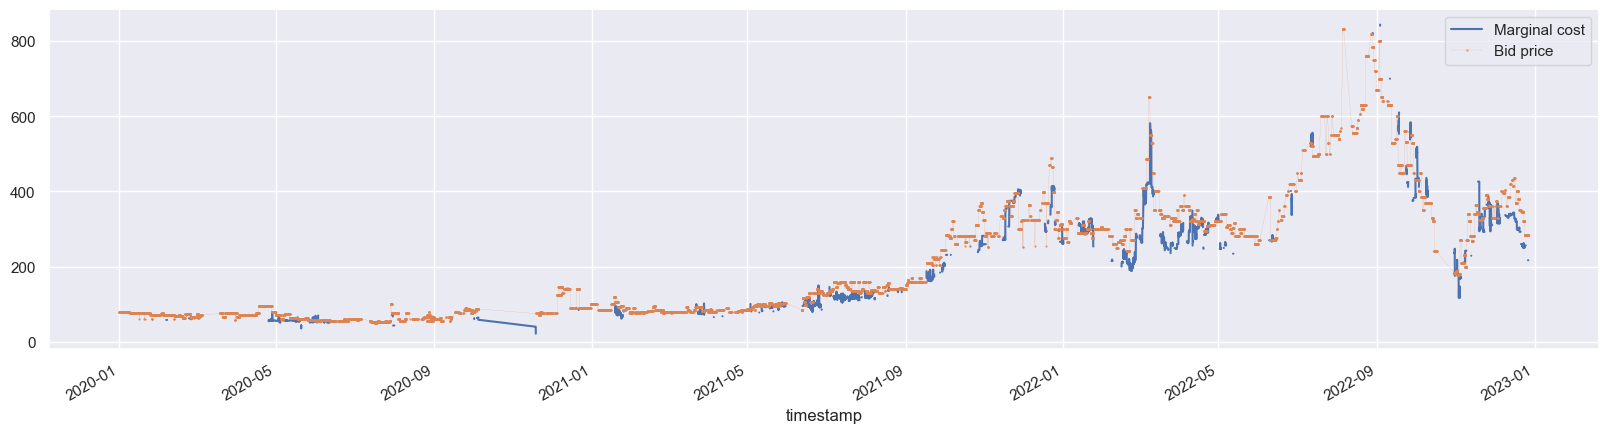

In [69]:
fig, ax = plt.subplots(figsize=(20, 5))
sim_df.cost.plot(label='Marginal cost')
sim_df.Price.plot(ax=ax, label='Bid price', marker='.', markersize=1, linewidth=0.1)
# sim_df.MGPprice.plot(label='MGP price')
plt.legend()

## Interpolate the marginal costs to fill the na values

<Axes: xlabel='timestamp'>

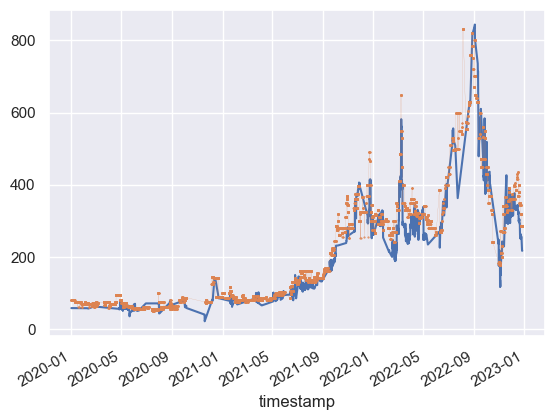

In [70]:
sim_df.cost.interpolate(method='time', limit_direction='both').plot()
sim_df.Price.plot(ax=plt.gca(), label='Bid price', marker='.', markersize=1, linewidth=0.1)

In [71]:
sim_df['cost'] = sim_df['cost'].interpolate(method='time', limit_direction='both')

## Find the optimal price for each bid

### Determine the range of prices for the search

<Axes: >

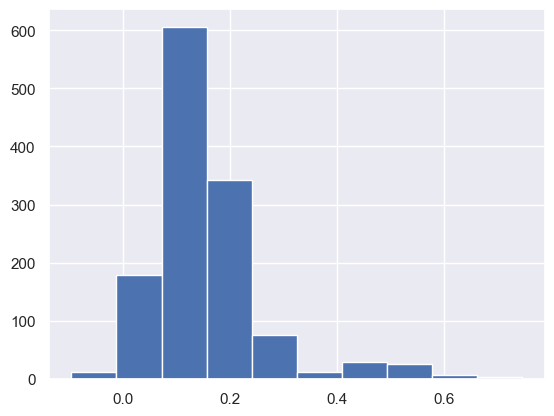

In [72]:
# Distribution of the price difference of the accepted bids, just for the unit considered
sim_df[sim_df.Result].PriceDiff.hist()

<Axes: >

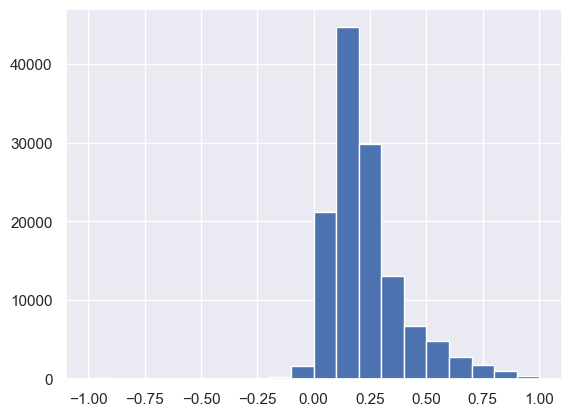

In [73]:
# Distribution of the price difference of the accepted bids, for all units
df[df.Result].PriceDiff.hist(bins=20)
# df[(df.Result) & (df.MGPprice > 50)].PriceDiff.hist(bins=20)

In [74]:
price_diff_range = {
    'OFF': (0, 1/3),
    'BID': (-0.5, 0)
}

### Get optimal price

In [75]:
def get_optimal_price_and_prob(bid, model, calibrator, price_diff_range, n_prices, scope, marginal_cost, return_smoothed=False, max_price=None):
    simulated_bids = pd.concat([bid] * n_prices, ignore_index=True)
    price_diff = np.linspace(*price_diff_range, n_prices)

    simulated_bids['PriceDiff'] = price_diff
    simulated_bids['Price'] = simulated_bids['MGPprice'] * (1 + simulated_bids['PriceDiff']) / (1 - simulated_bids['PriceDiff'])
    if max_price:
        simulated_bids['Price'] = simulated_bids['Price'].clip(upper=max_price)
        simulated_bids['PriceDiff'] = ((simulated_bids['Price'] - simulated_bids['MGPprice']) / (simulated_bids['MGPprice'] + simulated_bids['Price']).abs()).fillna(0)
    simulated_bids['y_probs'] = predict_acc_prob(simulated_bids, model, calibrator=calibrator)
    simulated_bids['y_probs_smoothed'] = savgol_filter(simulated_bids.y_probs, window_length=80, polyorder=3, mode='nearest')

    if scope == 'OFF':
        simulated_bids['Expected Profit'] = (simulated_bids['Price'] - marginal_cost) * simulated_bids['y_probs_smoothed']
    elif scope == 'BID':
        simulated_bids['Expected Profit'] = (marginal_cost - simulated_bids['Price']) * simulated_bids['y_probs_smoothed']
    
    return simulated_bids.loc[simulated_bids['Expected Profit'].argmax(), ['Price', 'y_probs' + return_smoothed * '_smoothed']].values

In [76]:
n_prices = 300
months = sim_df.month.unique()

for month in tqdm(months):

    model = joblib.load(join(model_folder, '{}.joblib'.format(month.strftime('%Y%m'))))
    calibrator = joblib.load(join(calibrator_folder, '{}.joblib'.format(month.strftime('%Y%m'))))

    indices = sim_df[sim_df.month == month].index
    
    for idx in indices:
        bid = sim_df[sim_df.index == idx]
        marginal_cost = bid.cost.values[0]
        price, prob = get_optimal_price_and_prob(bid, model, calibrator, price_diff_range[scope], n_prices, scope, marginal_cost)
        sim_df.loc[idx, 'Price_opt'] = price
        sim_df.loc[idx, 'y_probs_opt'] = prob

  0%|          | 0/36 [00:00<?, ?it/s]

In [77]:
sim_df.to_pickle(f'data/3_output/optimal_prices_{unit[scope]}.pkl')
sim_df = pd.read_pickle(f'data/3_output/optimal_prices_{unit[scope]}.pkl')

### Compute actual profit, expected profit under current pricing and expected profit under optimal pricing

In [78]:
# Acceptance rate quantity may vary for the unit depending on the year
acc_ratio = sim_df[sim_df.Result].groupby('year')['RatioAcc'].mean()
acc_ratio

year
2020    0.224639
2021    0.199537
2022    0.137941
Name: RatioAcc, dtype: float64

In [79]:
df[df.Result].groupby('year')['RatioAcc'].mean()

year
2018    0.389553
2019    0.296393
2020    0.290681
2021    0.298827
2022    0.285047
Name: RatioAcc, dtype: float64

<Axes: xlabel='timestamp'>

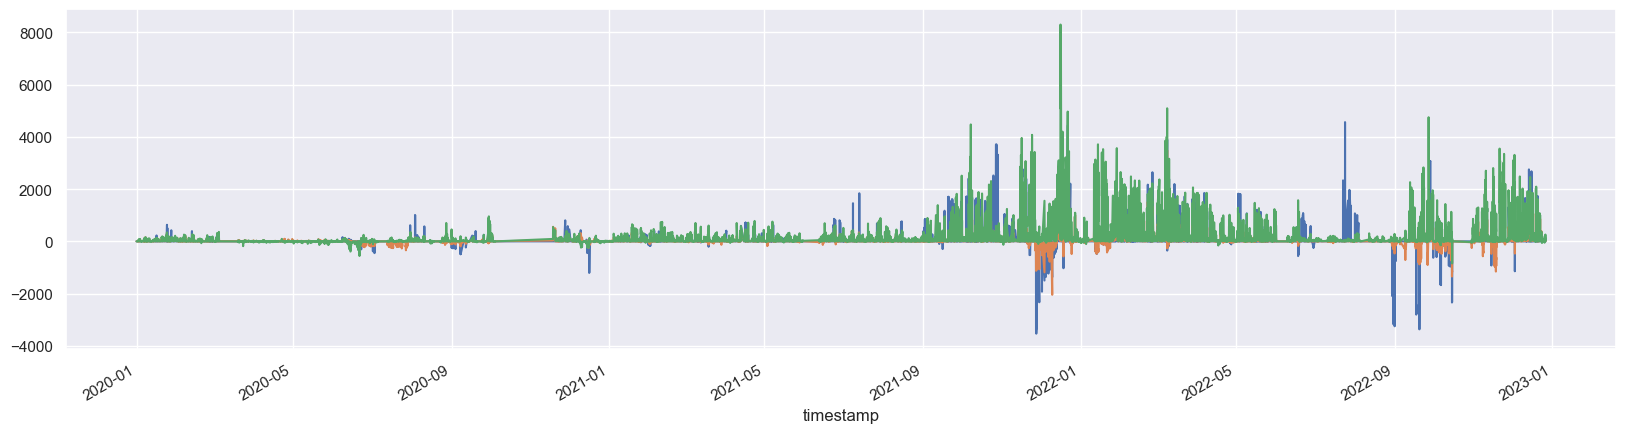

In [80]:
plt.figure(figsize=(20, 5))
profit_sign = 1 if scope == 'OFF' else -1
sim_df['profit_real'] = sim_df.Result * sim_df.RatioAcc * sim_df.Qty * profit_sign * (sim_df.Price - sim_df.cost)
sim_df['exp_profit_model'] = sim_df.y_probs * sim_df.year.map(acc_ratio) * sim_df.Qty * profit_sign * (sim_df.Price - sim_df.cost)
sim_df['exp_profit_opt'] = sim_df.y_probs_opt * sim_df.year.map(acc_ratio) * sim_df.Qty * profit_sign * (sim_df.Price_opt - sim_df.cost)
sim_df.profit_real.plot()
sim_df.exp_profit_model.plot()
sim_df.exp_profit_opt.plot()

<Axes: xlabel='month'>

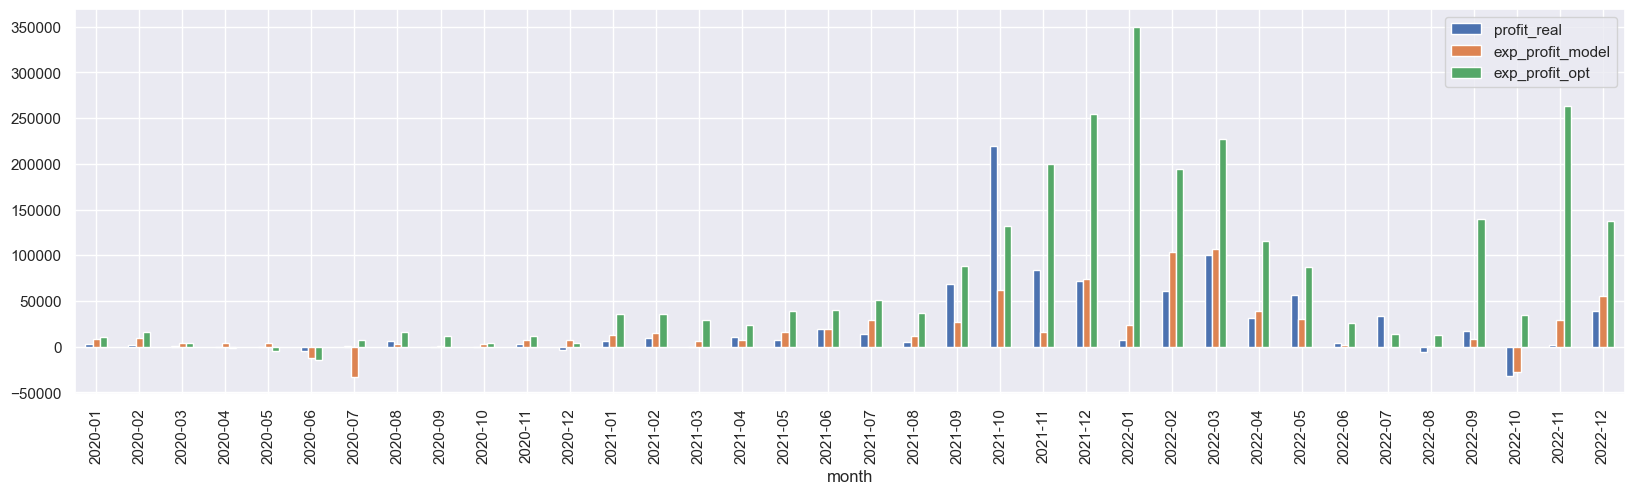

In [81]:
plot_df = sim_df.groupby('month')[['profit_real', 'exp_profit_model', 'exp_profit_opt']].sum()
plot_df.plot.bar(legend=True, figsize=(20,5))

<Axes: xlabel='timestamp'>

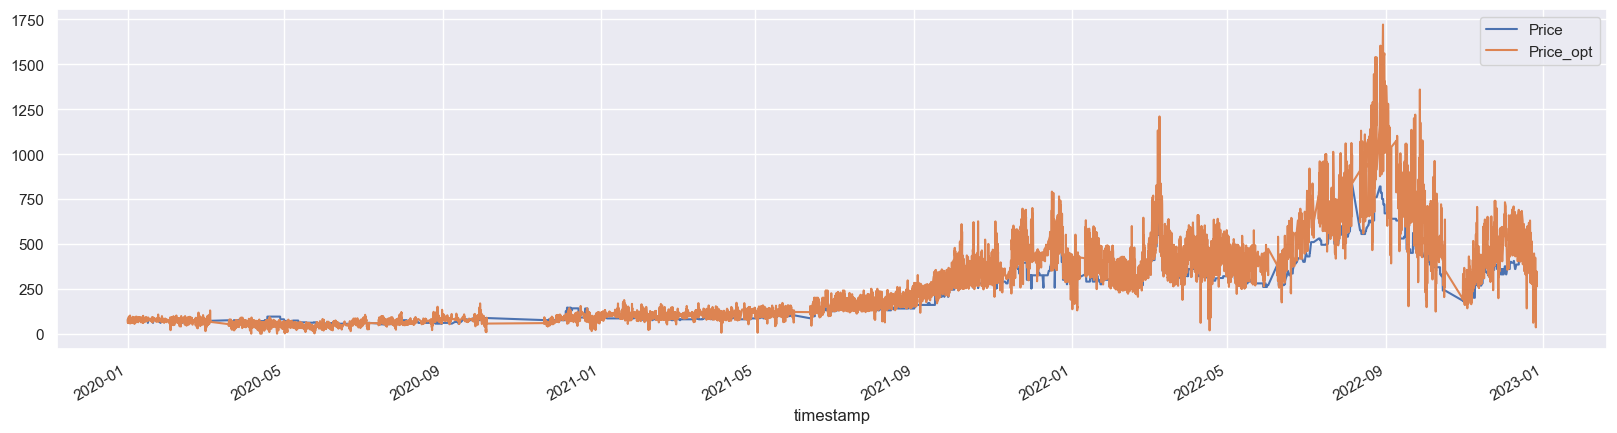

In [82]:
sim_df[['Price', 'Price_opt']].plot(figsize=(20, 5))

<Axes: xlabel='month'>

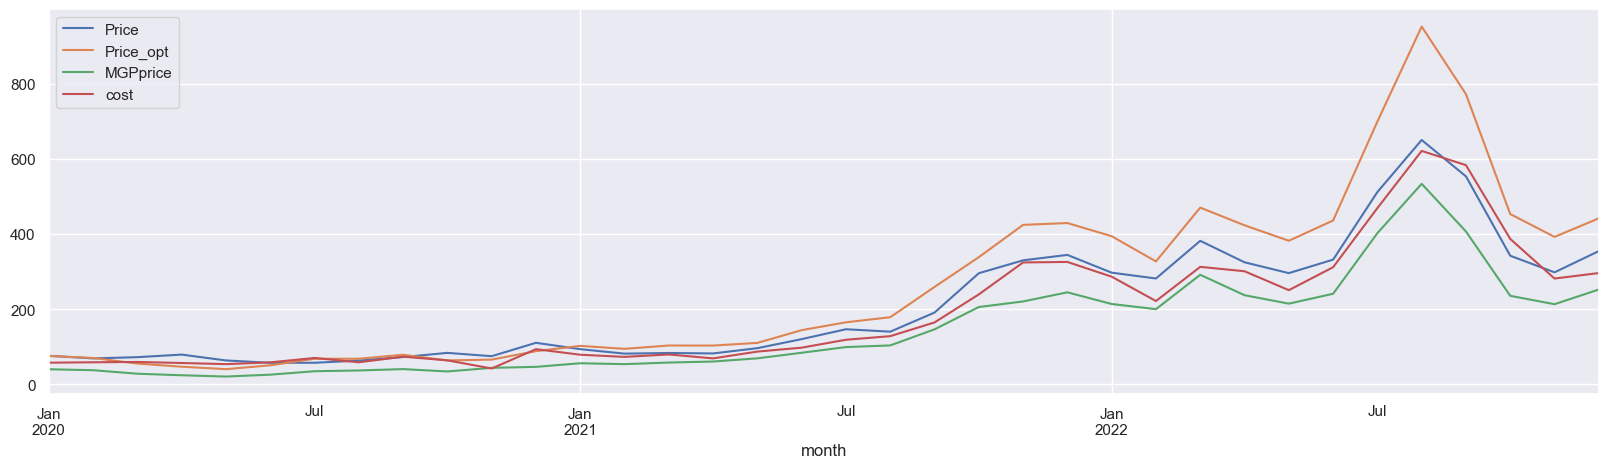

In [83]:
sim_df.groupby('month')[['Price', 'Price_opt', 'MGPprice', 'cost']].mean().plot(figsize=(20, 5))

## Run $N$ market simulations

In [84]:
def sample_acc_rate(year, n):
    return sim_df[(sim_df.Result) & (sim_df.year == year)].RatioAcc.sample(n=n, replace=True).values

In [85]:
df_list = []
n_sim = 1000
np.random.seed(42)

for b in tqdm(range(n_sim)):
    run_df = pd.DataFrame(index=sim_df.index)

    run_df['RatioAcc_model'] = np.concatenate([sample_acc_rate(year, len(sim_df[sim_df.year == year])) for year in years])
    run_df['RatioAcc_opt'] = np.concatenate([sample_acc_rate(year, len(sim_df[sim_df.year == year])) for year in years])

    run_df['Result_model'] = np.random.binomial(n=1, p=sim_df.y_probs, size=len(sim_df))
    run_df['Result_opt'] = np.random.binomial(n=1, p=sim_df.y_probs_opt.clip(lower=0), size=len(sim_df))

    run_df['profit_model'] = run_df['Result_model'] * run_df['RatioAcc_model'] * sim_df.Qty * profit_sign * (sim_df.Price - sim_df.cost)
    run_df['profit_opt'] = run_df['Result_opt'] * run_df['RatioAcc_opt'] * sim_df.Qty * profit_sign * (sim_df.Price_opt - sim_df.cost)

    run_df['run'] = b
    run_df.reset_index(inplace=True)
    df_list.append(run_df)

runs_df = pd.concat(df_list, ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
runs_df

,timestamp,RatioAcc_model,RatioAcc_opt,Result_model,Result_opt,profit_model,profit_opt,run
0,2020-01-01 00:00:00,0.192007,0.105433,0,0,0.0,0.0,0
1,2020-01-01 01:00:00,0.233333,0.241379,0,0,0.0,0.0,0
2,2020-01-01 02:00:00,0.189189,0.156083,0,0,0.0,0.0,0
3,2020-01-01 03:00:00,0.195804,0.241379,0,0,0.0,0.0,0
4,2020-01-01 04:00:00,0.241379,0.269231,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
17577995,2022-12-26 19:00:00,0.078014,0.108108,0,0,0.0,0.0,999
17577996,2022-12-26 20:00:00,0.181818,0.108911,0,0,0.0,0.0,999
17577997,2022-12-26 21:00:00,0.108108,0.125000,0,0,0.0,0.0,999
17577998,2022-12-26 22:00:00,0.218750,0.067797,0,0,0.0,0.0,999


## Compare results between actual, model under adopted pricing and model under optimal pricing

<Axes: xlabel='month', ylabel='profit_value'>

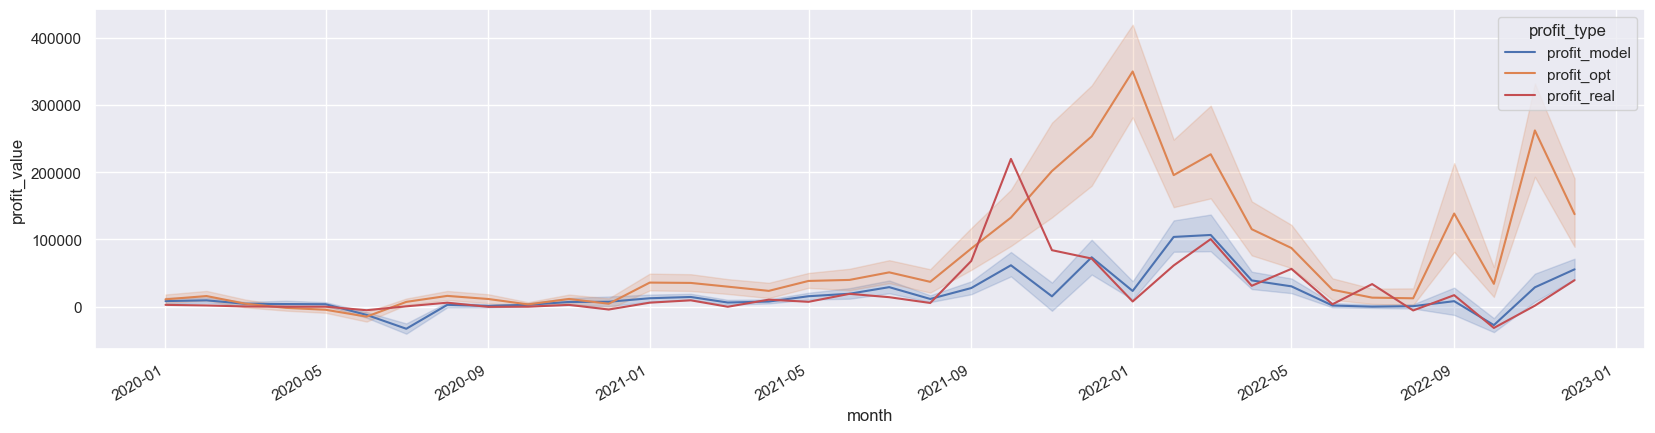

In [87]:
runs_df['month'] = runs_df.timestamp.dt.to_period('M').dt.to_timestamp()
month_profs = runs_df.groupby(['month', 'run'], as_index=False)[['profit_model', 'profit_opt']].sum()
month_profs = pd.melt(
    month_profs,
    id_vars=['month', 'run'],        # Columns to keep as identifiers
    value_vars=['profit_model', 'profit_opt'],  # Columns to melt
    var_name='profit_type',           # New column name for the melted variable names
    value_name='profit_value'         # New column name for the melted values
)

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(
    data=month_profs,
    x='month',
    y='profit_value',
    hue='profit_type',
    ax=ax,
    errorbar='pi'
)

sim_df.groupby(sim_df.month.dt.to_timestamp())[['profit_real']].sum().plot(color='r', ax=ax)

In [88]:
profit_real_by_year = sim_df.groupby(sim_df.index.year.astype(str))['profit_real'].sum()

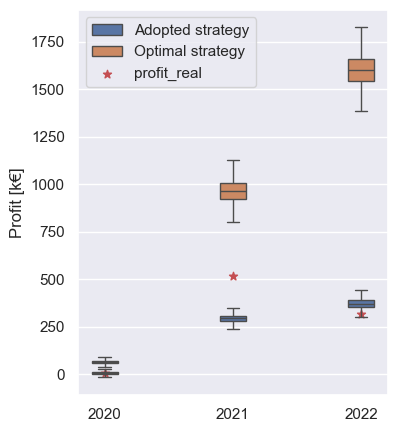

In [89]:
runs_df['year'] = runs_df.timestamp.dt.year
year_profs = runs_df.groupby(['year', 'run'], as_index=False)[['profit_model', 'profit_opt']].sum()
year_profs = pd.melt(
    year_profs,
    id_vars=['year', 'run'],        # Columns to keep as identifiers
    value_vars=['profit_model', 'profit_opt'],  # Columns to melt
    var_name='profit_type',           # New column name for the melted variable names
    value_name='profit_value'         # New column name for the melted values
)

year_profs['year'] = year_profs['year'].astype(str)
year_profs['profit_value'] = year_profs['profit_value'] / 1000

year_profs['profit_type'] = year_profs['profit_type'].map({'profit_model': 'Adopted strategy', 'profit_opt': 'Optimal strategy'})

fig, ax = plt.subplots(figsize=(4, 5))
ax = sns.boxplot(
    data=year_profs,
    x='year',
    y='profit_value',
    hue='profit_type',
    ax=ax,
    dodge=False,
    width=0.2,
    showfliers=False
)

# ax.set_ylim(bottom=0)

# Plot `profit_real` on top of the boxplot as red dots connected by lines
ax.scatter(
    profit_real_by_year.index,          # X-axis (years)
    profit_real_by_year.values / 1000,         # Y-axis (profit_real sums)
    color='r', marker='*', label="profit_real"
)

ax.set_xlabel(None)
ax.set_ylabel('Profit [k€]')

plt.legend()

In [90]:
profit_real_by_quarter = sim_df.groupby(sim_df.index.to_period('Q').astype(str))['profit_real'].sum()

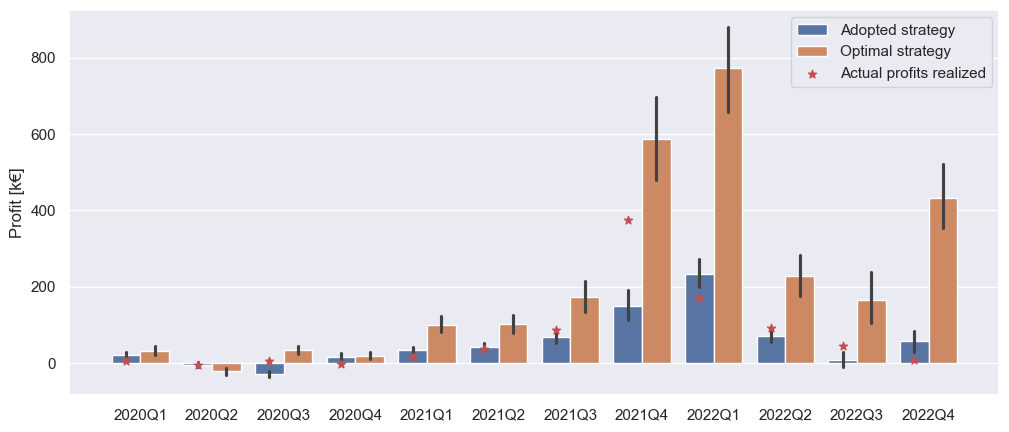

In [94]:
runs_df['quarter'] = runs_df.timestamp.dt.to_period('Q')
quarter_profs = runs_df.groupby(['quarter', 'run'], as_index=False)[['profit_model', 'profit_opt']].sum()
quarter_profs = pd.melt(
    quarter_profs,
    id_vars=['quarter', 'run'],        # Columns to keep as identifiers
    value_vars=['profit_model', 'profit_opt'],  # Columns to melt
    var_name='profit_type',           # New column name for the melted variable names
    value_name='profit_value'         # New column name for the melted values
)

quarter_profs['quarter'] = quarter_profs['quarter'].astype(str)
quarter_profs['profit_value'] = quarter_profs['profit_value'] / 1000

quarter_profs['profit_type'] = quarter_profs['profit_type'].map({'profit_model': 'Adopted strategy', 'profit_opt': 'Optimal strategy'})

fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.8
ax = sns.barplot(
    data=quarter_profs,
    x='quarter',
    y='profit_value',
    hue='profit_type',
    ax=ax,
    errorbar='pi',
    # dodge=False,
    width=bar_width,
    # showfliers=False
)

# Calculate the x positions of the bars
bar_positions = range(len(quarter_profs['quarter'].unique()))

# Calculate the offset for shifting points
offset = -bar_width / 4

# Plot profit_real points
ax.scatter(
    [bar_positions[i] + offset for i in range(len(profit_real_by_quarter.index))],  # Shifted positions
    profit_real_by_quarter.values / 1000,  # Adjusted Y-values
    color='r', marker='*', label="Actual profits realized", zorder=2
)

ax.set_xlabel(None)
ax.set_ylabel('Profit [k€]')

plt.legend()
plt.savefig(f'plots/{scope}/pricing/profits_strategies_{scope}.png', dpi=300)

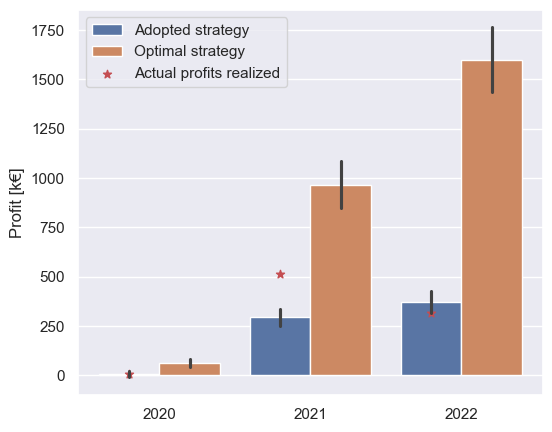

In [95]:
fig, ax = plt.subplots(figsize=(6, 5))
bar_width = 0.8
ax = sns.barplot(
    data=year_profs,
    x='year',
    y='profit_value',
    hue='profit_type',
    ax=ax,
    errorbar='pi',
    # dodge=False,
    width=bar_width,
    # showfliers=False
)

# Calculate the x positions of the bars
bar_positions = range(len(year_profs['year'].unique()))

# Calculate the offset for shifting points
offset = -bar_width / 4

# Plot profit_real points
ax.scatter(
    [bar_positions[i] + offset for i in range(len(profit_real_by_year.index))],  # Shifted positions
    profit_real_by_year.values / 1000,  # Adjusted Y-values
    color='r', marker='*', label="Actual profits realized"
)

ax.set_xlabel(None)
ax.set_ylabel('Profit [k€]')

plt.legend()

In [96]:
global_profs = year_profs.groupby(['profit_type', 'run'], as_index=False)['profit_value'].sum()
global_profs['profit_value'] = global_profs['profit_value'] / 1000
global_profs

,profit_type,run,profit_value
0,Adopted strategy,0,0.661945
1,Adopted strategy,1,0.601544
2,Adopted strategy,2,0.639693
3,Adopted strategy,3,0.698824
4,Adopted strategy,4,0.696554
...,...,...,...
1995,Optimal strategy,995,2.743586
1996,Optimal strategy,996,2.645890
1997,Optimal strategy,997,2.481832
1998,Optimal strategy,998,2.500384


In [102]:
# Define the format strings based on the scope
decimal_format = '{:.1f}' if scope == 'BID' else '{:.2f}'
range_format = '[{:.1f}, {:.1f}]' if scope == 'BID' else '[{:.2f}, {:.2f}]'

# Groupby and aggregation with conditional format
output_table = global_profs.groupby('profit_type').agg(**{
    'expected': ('profit_value', 'mean'),
    'PI 95%' : ('profit_value', lambda x: range_format.format(x.quantile(0.025), x.quantile(0.975)))
})

# Insert the 'realized' column with conditional format
output_table.insert(1, 'realized', [decimal_format.format(profit_real_by_year.sum() / 1e6), ''])

# Remove the index name
output_table.index.name = None

# Calculate percentage change and format conditionally
pct_change = (output_table.loc['Optimal strategy', 'expected'] - output_table.loc['Adopted strategy', 'expected']) / output_table.loc['Adopted strategy', 'expected']
output_table['expected'] = output_table['expected'].map(decimal_format.format)
output_table.loc['% change', :] = [f'{pct_change * 100:.0f}%', '', '']

output_table

,expected,realized,PI 95%
Adopted strategy,0.67,0.83,"[0.60, 0.74]"
Optimal strategy,2.63,,"[2.42, 2.83]"
% change,292%,,


In [103]:
output_table.to_csv(f'data/3_output/estimated_profits_{scope}.csv')

## Analysis of price competitivity between the two strategies

In [98]:
sim_df['PriceDiff_opt'] = ((sim_df['Price_opt'] - sim_df['MGPprice']) / (sim_df['MGPprice'] + sim_df['Price_opt']).abs()).round(3).fillna(0)

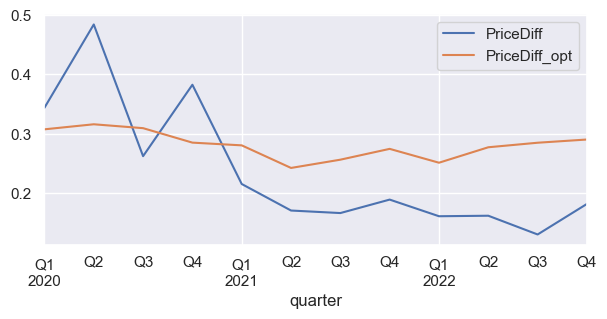

In [99]:
sim_df.groupby('quarter')[['PriceDiff', 'PriceDiff_opt']].mean().plot(figsize=(7,3))
# plt.ylim(bottom=0)
plt.show()

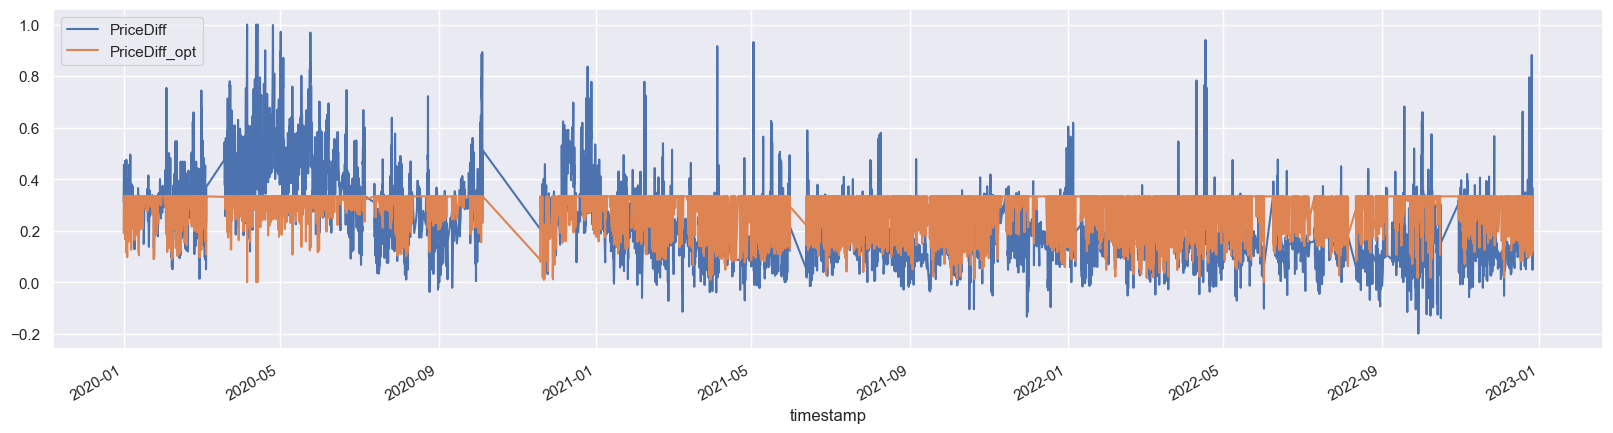

In [100]:
sim_df[['PriceDiff', 'PriceDiff_opt']].plot(figsize=(20,5))
# plt.ylim(bottom=0)
plt.show()

<Axes: >

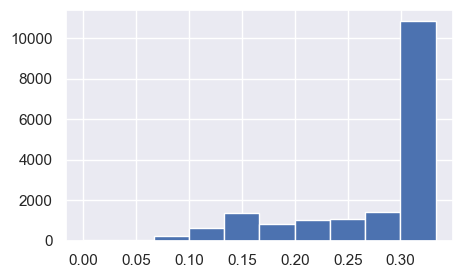

In [101]:
sim_df['PriceDiff_opt'].hist(figsize=(5, 3))

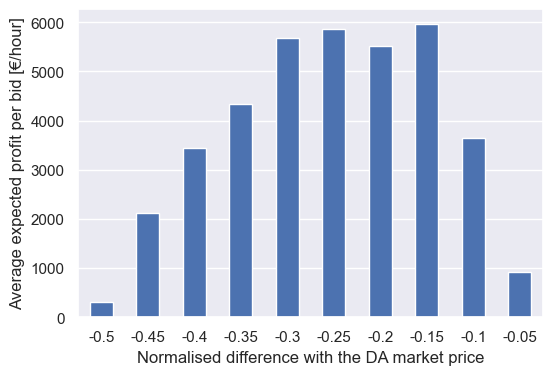

In [141]:
# FOR BID ONLY

sim_df.groupby(pd.cut(sim_df['PriceDiff_opt'], bins=np.arange(-0.525, 0.025, 0.05)), observed=False)['exp_profit_opt'].mean().plot(kind='bar', figsize=(6,4))
plt.grid(visible=False, axis='x')

# Set custom x-ticks
xticks = np.arange(-0.5, 0, 0.05)  # Define the desired x-ticks
plt.xticks(ticks=range(len(xticks)), labels=np.round(xticks, 2), rotation=0)
plt.xlabel('Normalised difference with the DA market price')
plt.ylabel('Average expected profit per bid [€/hour]')
plt.show()

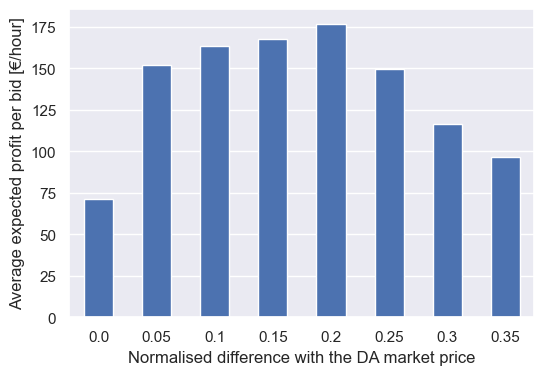

In [47]:
# FOR OFF ONLY

sim_df.groupby(pd.cut(sim_df['PriceDiff_opt'], bins=np.arange(-0.025, 0.425, 0.05)), observed=False)['exp_profit_opt'].mean().plot(kind='bar', figsize=(6,4))
plt.grid(visible=False, axis='x')

# Set custom x-ticks
xticks = np.arange(0, 0.4, 0.05)   # Define the desired x-ticks
plt.xticks(ticks=range(len(xticks)), labels=np.round(xticks, 2), rotation=0)
plt.xlabel('Normalised difference with the DA market price')
plt.ylabel('Average expected profit per bid [€/hour]')
plt.show()

<HR>

# TESTS

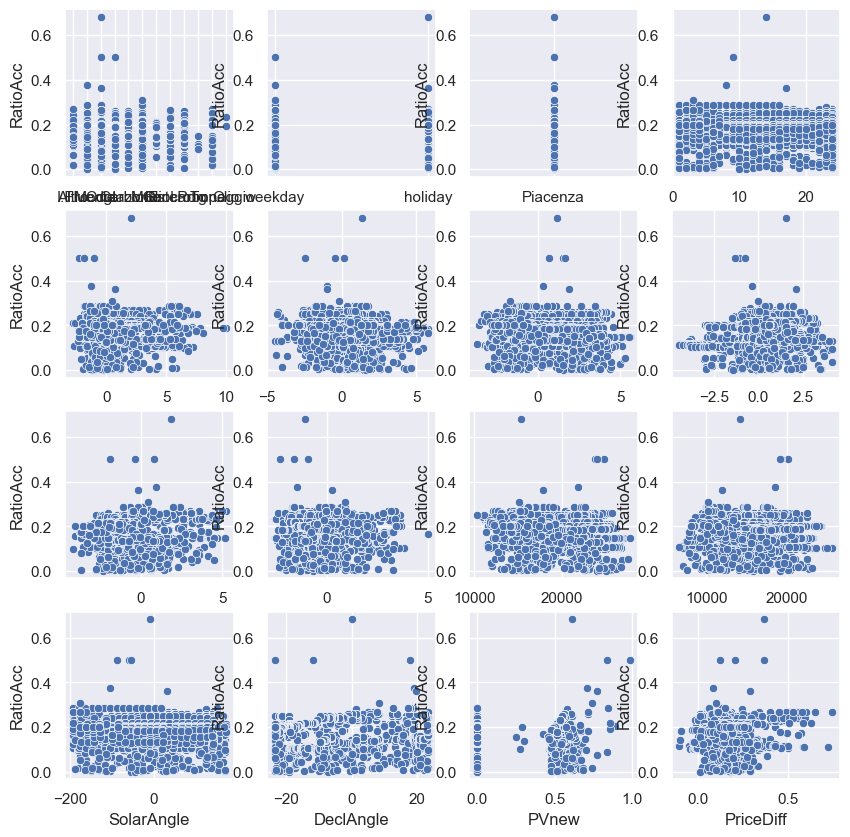

In [50]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, col in enumerate(features_to_encode[:-1]+other_features):
    sns.scatterplot(data=df[df.Result & (df.unit == unit[scope])], x=col, y='RatioAcc', ax=axs[i//4, i%4])